### XGBoosting

https://nbviewer.jupyter.org/github/jphall663/interpretable_machine_learning_with_python/blob/master/xgboost_pdp_ice.ipynb?flush_cache=trueXGBoosting


In [1]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
#import shapely as shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(42)               # set random seed for reproducibility

#### Import data and clean

In [2]:
# import XLS file
path = ".\\credit_cards_dataset.csv"
#data = pd.read_excel(path, skiprows=1) # skip the first row of the spreadsheet

#path = 'C:\\Users\\User\\Desktop\\data\\original_data.csv'
#data = pd.read_csv(path, skiprows=1) # skip the first row of the spreadsheet
data = pd.read_csv(path) # skip the first row of the spreadsheet

In [3]:
# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

In [4]:
data.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [5]:
'''
import pandas_profiling
data.profile_report(style={'full_width':True})
'''

"\nimport pandas_profiling\ndata.profile_report(style={'full_width':True})\n"

In [6]:
#profile.to_file(outputfile="my.html")

In [7]:
data.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,6,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,7,500000.0,1,1,2,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,8,100000.0,2,2,2,23,0,-1,-1,0,0,-1,11876.0,380.0,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,9,140000.0,2,3,1,28,0,0,2,0,0,0,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,-1,-1,0.0,0.0,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


In [8]:
# assign target and inputs for GBM
#y = 'DEFAULT_NEXT_MONTH'
y='default.payment.next.month'
X = [name for name in data.columns if name not in [y, 'ID', 'Y_Value']]
print('y =', y)
print('X =', X)

y = default.payment.next.month
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [9]:
data[X].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [10]:
data[X]

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
29996,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0
29997,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
29998,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


In [11]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [12]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1]

,default.payment.next.month
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


In [13]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

In [14]:
np.random.seed(42) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21087, columns = 25
Test data rows = 8913, columns = 25


In [15]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

In [16]:
# used to calibrate predictions to mean of y
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'auc',                       # stop training based on maximum AUC, AUC always between 0-1
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 42                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress

[0]	train-auc:0.77317	eval-auc:0.75410
[1]	train-auc:0.77538	eval-auc:0.75326
[2]	train-auc:0.78082	eval-auc:0.75982
[3]	train-auc:0.78091	eval-auc:0.75952
[4]	train-auc:0.78143	eval-auc:0.75910
[5]	train-auc:0.78341	eval-auc:0.76216
[6]	train-auc:0.78499	eval-auc:0.76386
[7]	train-auc:0.78464	eval-auc:0.76344
[8]	train-auc:0.78577	eval-auc:0.76423
[9]	train-auc:0.78614	eval-auc:0.76556
[10]	train-auc:0.78597	eval-auc:0.76514
[11]	train-auc:0.78671	eval-auc:0.76669
[12]	train-auc:0.78716	eval-auc:0.76679
[13]	train-auc:0.78738	eval-auc:0.76674
[14]	train-auc:0.78783	eval-auc:0.76775
[15]	train-auc:0.78796	eval-auc:0.76772
[16]	train-auc:0.78837	eval-auc:0.76776
[17]	train-auc:0.78868	eval-auc:0.76797
[18]	train-auc:0.78893	eval-auc:0.76827
[19]	train-auc:0.78904	eval-auc:0.76840
[20]	train-auc:0.78931	eval-auc:0.76840
[21]	train-auc:0.78943	eval-auc:0.76850
[22]	train-auc:0.78960	eval-auc:0.76876
[23]	train-auc:0.78966	eval-auc:0.76885
[24]	train-auc:0.78971	eval-auc:0.76885
[25]	train

In [17]:
# dtest is DMatrix
# shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True, ntree_limit=xgb_model.best_ntree_limit)

In [18]:
ypred=xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)

In [19]:
ypred.reshape(-1,1)
predictions = np.array([round(value) for value in ypred])

In [20]:
predictions.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

accuracy = accuracy_score(test[y], predictions)
cm = confusion_matrix(test[y], predictions)
precision = precision_score(test[y], predictions)
recall = recall_score(test[y], predictions)

In [22]:
print(accuracy)
print(cm)
print(precision)
print(recall)

0.815999102434646
[[6591  314]
 [1326  682]]
0.6847389558232931
0.3396414342629482


In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[6591  314]
 [1326  682]]


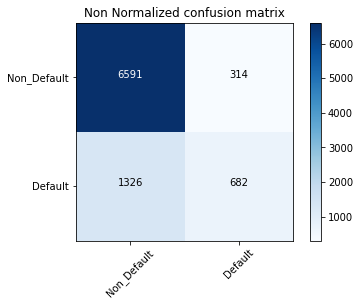

In [24]:
plt.figure()
plot_confusion_matrix(cm, classes=['Non_Default','Default'], normalize=False,
                      title='Non Normalized confusion matrix')

In [25]:
# plot Shapley variable importance summary
#import shap
#shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])
#shap.TreeExplainer(shap_values[:, :-1], test[xgb_model.feature_names])

In [26]:
#https://www.kaggle.com/dansbecker/shap-values

### PDP

In [27]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe, ntree_limit=model.best_ntree_limit))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

In [28]:
par_dep_PAY_0 = par_dep('PAY_0', test[X], xgb_model)         # calculate partial dependence for PAY_0
par_dep_LIMIT_BAL = par_dep('LIMIT_BAL', test[X], xgb_model) # calculate partial dependence for LIMIT_BAL
par_dep_BILL_AMT1 = par_dep('BILL_AMT1', test[X], xgb_model) # calculate partial dependence for BILL_AMT1

# display partial dependence for LIMIT_BAL
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence
0,10000.0,0.245412
1,59500.0,0.232416
2,109000.0,0.212855
3,158500.0,0.203638
4,208000.0,0.200841
5,257500.0,0.200011
6,307000.0,0.199269
7,356500.0,0.198937
8,406000.0,0.198911
9,455500.0,0.198697


In [29]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

In [30]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest))], axis=1)
yhat_test = yhat_test.rename(columns={0:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 17157,
 99: 14245,
 10: 5626,
 20: 24975,
 30: 21679,
 40: 5304,
 50: 21939,
 60: 3117,
 70: 10348,
 80: 5192,
 90: 18073}

### ICE

In [31]:
# retreive bins from original partial dependence calculation

bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_BILL_AMT1 = list(par_dep_BILL_AMT1['BILL_AMT1'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test[test['ID'] == int(percentile_dict[i])][X],  
                                    xgb_model, 
                                    bins=bins_PAY_0)['partial_dependence']
    
    # ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
                                          test[test['ID'] == int(percentile_dict[i])][X], 
                                          xgb_model, 
                                          bins=bins_LIMIT_BAL)['partial_dependence']
    


    # ICE curves for BILL_AMT1 across percentiles at bins_BILL_AMT1 intervals
    par_dep_BILL_AMT1[col_name] = par_dep('BILL_AMT1', 
                                          test[test['ID'] == int(percentile_dict[i])][X],  
                                          xgb_model, 
                                          bins=bins_BILL_AMT1)['partial_dependence']

In [32]:
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,10000.0,0.245412,0.066254,0.118925,0.126077,0.139623,0.175219,0.198680,0.180610,0.261332,0.246408,0.506714,0.937687
1,59500.0,0.232416,0.054184,0.107999,0.116435,0.124215,0.161549,0.182931,0.166589,0.253663,0.234709,0.473444,0.929809
2,109000.0,0.212855,0.028793,0.082658,0.096569,0.094446,0.142382,0.145176,0.143035,0.244169,0.227496,0.460180,0.920169
3,158500.0,0.203638,0.019948,0.072587,0.085842,0.084711,0.129335,0.134381,0.135365,0.241096,0.224442,0.450469,0.920169
4,208000.0,0.200841,0.019376,0.070087,0.082278,0.083200,0.126153,0.131959,0.130671,0.235277,0.224266,0.447872,0.920169
5,257500.0,0.200011,0.018903,0.069762,0.080686,0.082743,0.126153,0.131274,0.130671,0.232450,0.219349,0.446876,0.909215
6,307000.0,0.199269,0.018903,0.069762,0.080686,0.082743,0.126153,0.129176,0.130208,0.232450,0.218138,0.443274,0.909215
7,356500.0,0.198937,0.018903,0.069762,0.080440,0.082743,0.124142,0.128895,0.130208,0.232450,0.217983,0.440745,0.909215
8,406000.0,0.198911,0.018903,0.069762,0.080440,0.082743,0.124142,0.128895,0.130180,0.232450,0.217899,0.440745,0.909215
9,455500.0,0.198697,0.018379,0.069762,0.080440,0.082341,0.124085,0.128078,0.130180,0.232450,0.217899,0.440745,0.909215


### Plotting partial dependence and ICE to validate and explain monotonic behavior

In [33]:
#### Function to plot partial dependence and ICE

def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

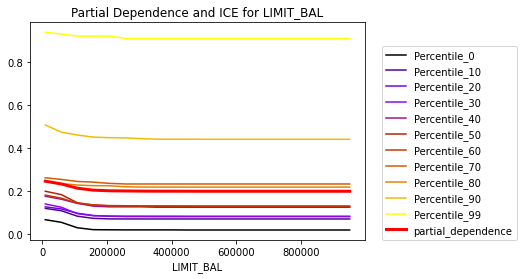

In [34]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) # plot partial dependence and ICE for LIMIT_BAL

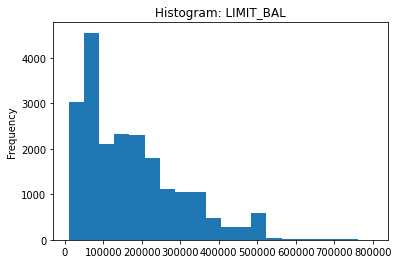

In [35]:
_ = train['LIMIT_BAL'].plot(kind='hist', bins=20, title='Histogram: LIMIT_BAL')

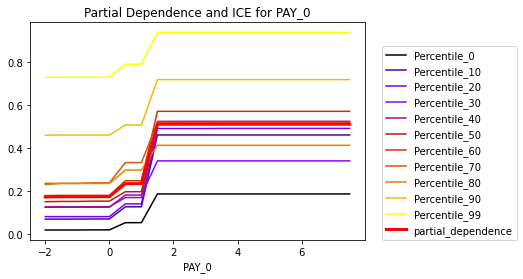

In [36]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0) # plot partial dependence and ICE for PAY_0

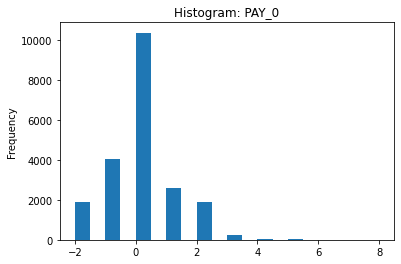

In [37]:
_ = train['PAY_0'].plot(kind='hist', bins=20, title='Histogram: PAY_0')

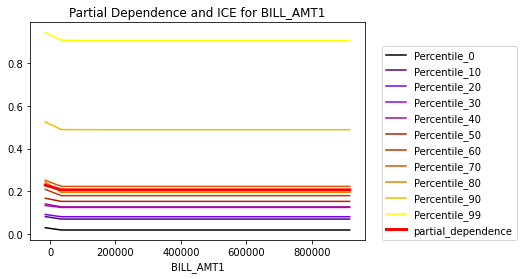

In [38]:
plot_par_dep_ICE('BILL_AMT1', par_dep_BILL_AMT1) # plot partial dependence and ICE for BILL_AMT1

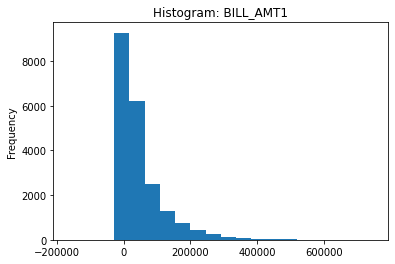

In [39]:
_ = train['BILL_AMT1'].plot(kind='hist', bins=20, title='Histogram: BILL_AMT1')

### Generate reason codes using the Shapley method

In [40]:
test.reset_index(drop=True, inplace=True)

In [41]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]

In [42]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

In [43]:
s_df

,Reason Codes
PAY_0,1.398445
PAY_2,0.591078
PAY_6,0.364922
PAY_5,0.243867
AGE,0.209559
MARRIAGE,0.164830
PAY_3,0.137433
BILL_AMT1,0.134336
LIMIT_BAL,0.126473
PAY_AMT3,0.096404


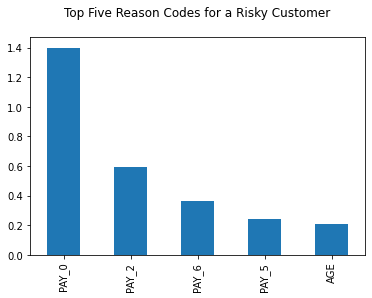

In [44]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Reason Codes for a Risky Customer\n', 
                  legend=False)

In [45]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
4173,14245,10000.0,1,2,1,50,2,2,7,7,7,7,2400.0,2400.0,2400.0,2400.0,2400.0,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,1
